# Modeling (without statistics)

In this tutorial we build a star object for signal computation, but streamline by omitting any demonstration of statistical modeling (for which there exist other tutorials).

You can use the default atmosphere extension module ``xpsi/surface_radiation_field/archive/hot/blackbody.pyx`` as described below. To run this tutorial, you should therefore make sure X-PSI is installed with default settings (no flags).  However, you’ll have to switch the contents of the ``xpsi/surface_radiation_field/local_variables.pyx`` extension, as instructed below, in order to change the mapping from global variables to local variables from the default.

In [1]:
%matplotlib inline

from __future__ import print_function, division

import os
import numpy as np
import math
import time

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm

import xpsi

from xpsi.global_imports import _c, _G, _dpr, gravradius, _csq, _km, _2pi

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 0.7.9               |
|---------------------------------------------|
|  https://thomasedwardriley.github.io/xpsi/  |
\=============================================/

Imported GetDist version: 0.3.1
Imported nestcheck version: 0.2.0


## Constructing a star

We need to build our star. The basic units for building a star are:

* the [Spacetime](spacetime.rst#xpsi.Spacetime.Spacetime) class;
* the [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) class;
* the [HotRegion](hotregion.rst#xpsi.HotRegion.HotRegion) class;
* the [Elsewhere](elsewhere.rst#xpsi.Elsewhere.Elsewhere) class (optionally used in conjuction with HotRegion instances);
* the [Everywhere](elsewhere.rst#xpsi.Elsewhere.Elsewhere) class (cannot be used with HotRegion instances);
* and four low-level user-modifiable routines for evaluation of a parametrised specific intensity model.

For this demonstration we will assume that the surface radiation field *elsewhere* (other than the hot regions) can be ignored in the soft X-ray regime our model instrument is sensitive to. We will not be utilizing the [Elsewhere](elsewhere.rst#xpsi.Elsewhere.Elsewhere) class, for which their exists a distinct tutorial (**Global surface emission**). For more advanced modelling, we can simply write custom *derived* classes, and instantiate those derived classes to construct objects for our model. In particular, a common pattern will be to subclass the [HotRegion](hotregion.rst#xpsi.HotRegion.HotRegion) class. Let's start with the [Spacetime](spacetime.rst#xpsi.Spacetime.Spacetime) class.

### The ambient spacetime

In [2]:
xpsi.Spacetime#? # uncomment to query

xpsi.Spacetime.Spacetime

We can instanciate the `spacetime` by defining all parameters with a given value.  In this case, all parameters will be fixed because the `bounds` are not specified (empty dictionary). **Note that all parameters must be defined at least once in `bounds` or `values`.** 

In [3]:
values = dict(distance =0.150,          # (Earth) distance
                mass = 1.5,             # mass
                radius = 12.0,          # equatorial radius
                cos_inclination = 0.5,  # (Earth) inclination to rotation axis
                frequency = 300. )      # spin frequency

spacetime = xpsi.Spacetime(bounds={}, values=values)

Creating parameter:
    > Named "frequency" with fixed value 3.000e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with fixed value 1.500e+00.
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with fixed value 1.200e+01.
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with fixed value 1.500e-01.
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with fixed value 5.000e-01.
    > Cosine of Earth inclination to rotation axis.


Alternatively we can specify bounds manually for the free parameters. Using `(None, None)` will set the default bounds. The fixed parameters are defined in the `values` dictionary.  If both the bounds and a value are defined for a parameters, the value will not be fixed but instead will be set as an initial value.

In [4]:
bounds = dict(distance = (None, None),                   # Default bounds for (Earth) distance
                mass = (None, None),                     # Default bounds for mass 
                radius = (None, None),                   # Default bounds for equatorial radius
                cos_inclination = (None, None))          # Default bounds for (Earth) inclination to rotation axis

values = dict(frequency=300.0,                           # Fixed spin frequency
              mass=1.4)                                  # mass with initial value

spacetime = xpsi.Spacetime(bounds=bounds, values=values)

Creating parameter:
    > Named "frequency" with fixed value 3.000e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e-03, 3.000e+00] and initial value 1.400e+00.
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [1.000e+00, 2.000e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-02, 3.000e+01].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [-1.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


To display the free parameters:

In [5]:
for p in spacetime:
    print(p)

Gravitational mass [solar masses].
Coordinate equatorial radius [km].
Earth distance [kpc].
Cosine of Earth inclination to rotation axis.


For the following example in this tutorial, we will specify the bounds of all parameters.

In [6]:
bounds = dict(distance = (0.1, 1.0),                     # (Earth) distance
                mass = (1.0, 3.0),                       # mass with default bounds
                radius = (3.0 * gravradius(1.0), 16.0),  # equatorial radius
                cos_inclination = (0.0, 1.0))            # (Earth) inclination to rotation axis

values = dict(frequency=300.0 )                          # Fixed spin frequency

spacetime = xpsi.Spacetime(bounds=bounds, values=values)

Creating parameter:
    > Named "frequency" with fixed value 3.000e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.000e+00].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


### The photosphere and its constituent regions

It is not necessary for us to write a custom derived class for the photosphere object, so we will simply instantiate a [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) object. However, we first need an instance of [HotRegion](hotregion.rst#xpsi.HotRegion.HotRegion) to instantiate the photosphere, and we need to implement a low-level parametrised model for the specific intensity emergent from the photosphere in a local comoving frame.

The neutron star atmosphere is assumed to be geometrically thin. In the applications thus far, the surface local-comoving-frame radiation field as being described by a single *free* parameter: the effective temperature. The radiation field is also dependent on the local effective gravitational acceleration, however this is a *derived* parameter in the model. The parametrised radiation field as a function of energy and angle subtended to the normal to the (plane-parallel) atmosphere in a local comoving frame is provided as numerical model data for multi-dimensional interpolation.

In X-PSI, integration over the surface radiation field is performed via calls to low-level C routines. To reduce likelihood evaluation times, the atmosphere interpolator is written in C, and calls to that interpolator are from C routine. In other words, in X-PSI, **we do not use Python callback functions for evaluation of specific intensities, but C functions which are compiled when the** X-PSI **package is built**. Unfortunately this means that to change the parametrised surface radiation field you need to get your hands a little dirty; on the bright side, the body of these functions can be implemented almost completely in the Cython language, so syntactically there is some similarity to Python because the language syntax is somewhat of a hybrid/superset. Beware, however, that the body of these functions must not contain calls to the Python API, and only to external C libraries if required: the code must evaluate to pure C, and not require the Python/C API. Note that the Python global interpreter lock is deactivated during integration to enable OpenMP multi-threading in some applications of the integrator; thus the code needs to be thread safe and ``nogil`` (not require the global interpreter lock, although a context manager could *in principle* be used to reacquire the lock within the integrator). Also note that if external C libraries are required, that you include a Cython .pxd (header) file in the package which ``extern``s the required library components; the library also needs to be included and linked in ``setup.py`` at package build-time.

*You are encouraged to ask the author of X-PSI for assistance in implementing your low-level surface radiation field model if you are uncertain. If you have ideas for making this model specification more user-friendly, without, crucially, increasing signal integration time, please contact the author or submit a pull request.*

The following is the contents of the ``hot.pxd`` file which the X-PSI integrators use as the header file for including other C functions in the package.

```cython
from preload cimport _preloaded

cdef double eval_hot(size_t THREAD,
                     double E,
                     double mu,
                     const double *const VEC,
                     void *const data) nogil

cdef double eval_hot_norm() nogil

cdef void* init_hot(size_t numThreads, const _preloaded *const preloaded) nogil

cdef int free_hot(size_t numThreads, void *const data) nogil
```

**You are free to modify these functions in the associated** ``hot.pyx`` **implementation file, and you have almost complete control over the function bodies, but not the signatures.** By default the package includes an isotropic blackbody model:

```cython
#cython: cdivision=True
#cython: boundscheck=False
#cython: nonecheck=False
#cython: wraparound=False

from libc.math cimport exp, pow

from xpsi.global_imports import _keV, _k_B

cdef int SUCCESS = 0

cdef double erg = 1.0e-7
cdef double Planck_dist_const = 5.040366110812353e22

cdef double k_B = _k_B
cdef double keV = _keV
cdef double k_B_over_keV = k_B / keV

#----------------------------------------------------------------------->>>
# >>> User modifiable functions.
# >>> Note that the user is entirely free to wrap thread-safe and
# ... non-parallel external C routines from an external library.
# >>> Thus the bodies of the following need not be written explicitly in
# ... the Cython language.
#----------------------------------------------------------------------->>>
cdef void* init_hot(size_t numThreads, const _preloaded *const preloaded) nogil:
    # This function must match the free management routine free_hot()
    # in terms of freeing dynamically allocated memory. This is entirely
    # the user's responsibility to manage.

    # Return NULL if dynamic memory is not required for the model.
    return NULL

cdef int free_hot(size_t numThreads, void *const data) nogil:
    # This function must match the initialisation routine init_hot()
    # in terms of freeing dynamically allocated memory. This is entirely
    # the user's responsibility to manage.
    # The void pointer must be appropriately cast before memory is freed --
    # only the user can know this at compile time.
    # Just use free(<void*> data) iff no memory was dynamically
    # allocated in the function:
    #   init_local_hot()
    # because data is expected to be NULL in this case

    #printf("\nNo data to be freed.")

    return SUCCESS

cdef double eval_hot(size_t THREAD,
                     double E,
                     double mu,
                     const double *const VEC,
                     void *const data) nogil:
    # Arguments:
    # E = photon energy in keV
    # mu = cosine of ray zenith angle (i.e., angle to surface normal)
    # VEC = variables such as temperature, effective gravity, ...
    # data = numerical model data required for intensity evaluation

    cdef double temp = k_B_over_keV * pow(10.0, VEC[0])

    return E * E * E / ( exp(E / temp) - 1.0 )

cdef double eval_hot_norm() nogil:
    # Source radiation field normalisation which is independent of the
    # parameters of the parametrised model -- i.e. cell properties, energy,
    # and angle.
    # Writing the normalisation here reduces the number of operations required
    # during integration.
    # The units of the specific intensity need to be J/cm^2/s/keV/steradian.

    return erg * Planck_dist_const
```

In most use-cases we need to modify these functions to enable handling of the numerical atmosphere data. An extension for such a case may be found as an [example](surface_radiation_field.rst#a-numerical-atmosphere), which contains the extension used by [Riley et al. (2019)](applications.rst#riley-et-al-2019-apjl-887-l21) to implement a numerical atmosphere generated by the NSX atmosphere code ([Ho, W.C.G & Lai, D. 2001](https://ui.adsabs.harvard.edu/abs/2001MNRAS.327.1081H/abstract); [Ho, W.C.G & Heinke, C.O. 2009](https://ui.adsabs.harvard.edu/link_gateway/2009Natur.462...71H/doi:10.1038/nature08525)), courtesy of W.C.G. Ho for NICER modeling efforts. A fully-ionized hydrogen atmosphere (Ho & Lai 2001) was used in [Riley et al. (2019)](applications.rst#riley-et-al-2019-apjl-887-l21); also see Bogdanov et al. (2020).

In general, if you wish to change the model for the parametrised surface local-comoving-frame radiation field model, you can archive the extensions in, e.g., the ``xpsi/surface_radiation_field/archive``, and completely replace the contents of ``xpsi/surface_radiation_field/hot.pyx`` when X-PSI is compiled and installed. Alternatively, you can compile your extension elsewhere and link it when X-PSI is installed (by editing the ``setup.py`` script), `cimporting` or `extern`ing from the appropriate `.pxd` header file(s), and calling those precompiled binaries from the functions declared in the ``xpsi/surface_radiation_field/hot.pxd`` header.

We now instantiate hot region objects. We can find the required and optional parameter names in the class docstring:

In [6]:
xpsi.HotRegion#? # uncomment to query

xpsi.HotRegion.HotRegion

The names can also be found as class attributes as follows (refer to the [HotRegion](hotregion.rst#xpsi.HotRegion.HotRegion) class docstring and [Riley et al. (2019)](applications.rst) for the meaning of *super*):

In [7]:
xpsi.HotRegion.required_names

['super_colatitude',
 'super_radius',
 'phase_shift',
 'super_temperature (if no custom specification)']

The condition *if no custom specification* means that this name is required if we do not supply custom parameters for the radiation field in the superseding member of the hot region. If we supply custom parameters, we also need to subclass ``xpsi.HotRegion`` and overwrite the ``__compute_cellParamVecs`` method to handle our parameters.

In [8]:
xpsi.HotRegion.optional_names

['omit_colatitude',
 'omit_radius',
 'omit_azimuth',
 'cede_colatitude',
 'cede_radius',
 'cede_azimuth',
 'cede_temperature']

For the purpose of illustration, we *tie* the temperatures of the hot regions together. There is more than one way to achieve this, but we will use the most powerful approach.

In [9]:
bounds = dict(super_colatitude = (None, None),
              super_radius = (None, None),
              phase_shift = (0.0, 0.1),
              super_temperature = (None, None))

# a simple circular, simply-connected spot
primary = xpsi.HotRegion(bounds=bounds,
                            values={}, # no initial values and no derived/fixed
                            symmetry=True,
                            omit=False,
                            cede=False,
                            concentric=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            num_leaves=100,
                            num_rays=200,
                            do_fast=False,
                            prefix='p') # unique prefix needed because >1 instance

Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].


Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].


Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000e-01].
    > The phase of the hot region, a periodic parameter [cycles].


Creating parameter:
    > Named "super_temperature" with bounds [3.000e+00, 7.000e+00].
    > log10(superseding region effective temperature [K]).




Note that since the atmospheric local-comoving-frame effective temperature is uniform everywhere within the hot region boundaries, we can use the default value of the ``symmetry`` keyword, ``True``. All other arguments determine the numerical resolution, and have defaults which have been (somewhat arbitrarily) chosen to be result in a likelihood evaluation time of $\mathcal{O}(1)$ s.

Let's take a look at the ``xpsi.Derive`` docstring for guidance:

In [10]:
xpsi.Derive#? # uncomment to query

xpsi.Parameter.Derive

In [11]:
class derive(xpsi.Derive):
    def __init__(self):
        """
        We can pass a reference to the primary here instead
        and store it as an attribute if there is risk of
        the global variable changing.
        
        This callable can for this simple case also be
        achieved merely with a function instead of a magic
        method associated with a class.
        """
        pass

    def __call__(self, boundto, caller = None):
        # one way to get the required reference
        global primary # unnecessary, but for clarity
        return primary['super_temperature'] - 0.2
    
bounds['super_temperature'] = None # declare fixed/derived variable

secondary = xpsi.HotRegion(bounds=bounds, # can otherwise use same bounds
                              values={'super_temperature': derive()}, # create a callable value
                              symmetry=True,
                              omit=False,
                              cede=False,
                              concentric=False,
                              sqrt_num_cells=32,
                              min_sqrt_num_cells=10,
                              max_sqrt_num_cells=100,
                              num_leaves=100,
                              num_rays=200,
                              do_fast=False,
                              is_antiphased=True,
                              prefix='s') # unique prefix needed because >1 instance

Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].


Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].


Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000e-01].
    > The phase of the hot region, a periodic parameter [cycles].


Creating parameter:
    > Named "super_temperature" that is derived from ulterior variables.
    > log10(superseding region effective temperature [K]).




The description *derived from ulterior variables* means that when we lookup the value, it is calculated dynamically from the values of other (ulterior) model parameters. We clearly expect the temperature of the secondary hot region to behave in this way. A few other varibles do to because of keyword arguments passed upon instantiation of the hot regions. For example, the colatitude of the *zero-radii* omission and ceding regions (``omit=False`` and ``cede=False``) are equivalent to the colatitude of the centre of the superseding region. The azimuths are *relative* to the superseding region, and are thus listed as being *fixed* at zero azimuthal separation. If one of ``omit`` or ``cede`` was ``True``, and ``concentric=True``, a similar setup is performed, but with the radius of ``omit`` or ``cede`` being free, fixed (at finite value, but zero achieves the same as ``False`` for both ``omit`` and ``cede`` keyword arguments), or derived.

We now need to encapsulate the hot region instances in a container with properties expected by the ``Photosphere`` class.

In [12]:
from xpsi import HotRegions

hot = HotRegions((primary, secondary))

Let's check out the hot regions:

In [13]:
hot.objects[0] # 'p'

Free parameters
---------------
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).

Derived/fixed parameters
------------------------
p__cede_colatitude: The colatitude of the centre of the ceding region [radians].
p__cede_radius: The angular radius of the (circular) ceding region [radians].
p__cede_azimuth: The azimuth of the centre of the ceding region relative to the
centre of the superseding region [radians].
p__omit_colatitude: The colatitude of the centre of the omission region [radians].
p__omit_radius: The angular radius of the (circular) omission region [radians].
p__omit_azimuth: The azimuth of the centre of the omission region relative to the
centre of the superseding region [radians].

In [14]:
hot.objects[1] # 's'

Free parameters
---------------
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].

Derived/fixed parameters
------------------------
s__super_temperature: log10(superseding region effective temperature [K]).
s__cede_colatitude: The colatitude of the centre of the ceding region [radians].
s__cede_radius: The angular radius of the (circular) ceding region [radians].
s__cede_azimuth: The azimuth of the centre of the ceding region relative to the
centre of the superseding region [radians].
s__omit_colatitude: The colatitude of the centre of the omission region [radians].
s__omit_radius: The angular radius of the (circular) omission region [radians].
s__omit_azimuth: The azimuth of the centre of the omission region relative to the
centre of the superseding region [radians].

A list of names, with the prefix, can also be accessed as follows:

In [15]:
h = hot.objects[0]
h.names

['p__phase_shift',
 'p__super_colatitude',
 'p__super_radius',
 'p__super_temperature',
 'p__cede_colatitude',
 'p__cede_radius',
 'p__cede_azimuth',
 'p__omit_colatitude',
 'p__omit_radius',
 'p__omit_azimuth']

In [16]:
h.prefix

'p'

In [17]:
h.get_param('phase_shift')

The phase of the hot region, a periodic parameter [cycles]

Let's set a value for the temperature of the primary hot region:

In [18]:
hot['p__super_temperature'] = 6.0 # equivalent to ``primary['super_temperature'] = 6.0``

Now let's lookup the temperature of the secondary:

In [19]:
secondary['super_temperature']

5.8

No value was set explicitly for this secondary temperature: it is looked up dynamically from that of the primary hot region.

Note that the following access will *not* work:

In [20]:
# hot['s__super_temperature']

The reason for this is because the temperature of the secondary hot region is a *fixed/derived* variable. Only *free* model parameters are merged into larger spaces. A fixed/derived variable needs to be accessed via the subspace that directly encapsulates a reference to it.

We can now instantitate the photosphere:

In [21]:
class CustomPhotosphere(xpsi.Photosphere):
    """ Implement method for imaging."""
    
    @property
    def global_variables(self):
        """ This method is needed if we also want to ivoke the image-plane signal simulator. """
    
        return np.array([self['p__super_colatitude'],
                          self['p__phase_shift'] * _2pi,
                          self['p__super_radius'],
                          self['p__super_temperature'],
                          self['s__super_colatitude'],
                          (self['s__phase_shift'] + 0.5) * _2pi,
                          self['s__super_radius'],
                          self.hot.objects[1]['s__super_temperature']])

In [22]:
photosphere = CustomPhotosphere(hot = hot, elsewhere = None,
                                values=dict(mode_frequency = spacetime['frequency']))

Creating parameter:
    > Named "mode_frequency" with fixed value 3.000e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].




In [23]:
photosphere['mode_frequency'] == spacetime['frequency']

True

We do not model the surface radiation field *elsewhere*, and we thus leave the ``elsewhere`` keyword as ``None`` (the default). *Elsewhere* means on the surface, exterior to radiating hot regions that are typically expected to span a smaller angular extent; in the current version, the radiation from *elsewhere*, if explicitly computed is assumed to be time-invariant supposing the hot regions were not present. To account for radiation from *elsewhere*, a time-invariant signal is first computed, meaning an axisymmetric surface local-comoving-frame radiation field is assumed. The time-dependent signals from the hot regions are then computed, and modified by subtracting the specific intensity that would otherwise be generated by the surface local-comoving-frame radiation field from *elsewhere* (i.e., in place of the hot regions).  

### Star

We can now combine the ambient spacetime, ``spacetime``, and the embedded photosphere, ``photosphere``, into a model star represented by an instance of [Star](star.rst#xpsi.Star.Star). We do not need to extend this class, so we can simply construct and instantiate a star as follows:

In [24]:
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

Let's check out the star object, which merged parameter subspaces associated with objects lower in the hierarchy:

In [25]:
star

Free parameters
---------------
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
cos_inclination: Cosine of Earth inclination to rotation axis.
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].

Note that only the free parameters are merged into a subspace higher in the object hierarchy. The reason for this is
that there is not a clear and common pattern (at present) for accessing fixed/derived variables outside of the primary subspace to which they belong. If you try hard enough, of course, you can still get at them.

In [26]:
len(star)

11

Let's specify a parameter vector to the ``star`` subspace with the true model parameter values that we injected to generate the synthetic data rendered above:

In [27]:
p = [1.4,
     12.5,
     0.2,
     math.cos(1.25),
     0.0,
     1.0,
     0.075,
     6.2,
     0.025,
     math.pi - 1.0,
     0.2]

star(p)

The order of the parameters is as follows:

In [28]:
star.params

[Gravitational mass [solar masses] = 1.400e+00,
 Coordinate equatorial radius [km] = 1.250e+01,
 Earth distance [kpc] = 2.000e-01,
 Cosine of Earth inclination to rotation axis = 3.153e-01,
 The phase of the hot region, a periodic parameter [cycles] = 0.000e+00,
 The colatitude of the centre of the superseding region [radians] = 1.000e+00,
 The angular radius of the (circular) superseding region [radians] = 7.500e-02,
 log10(superseding region effective temperature [K]) = 6.200e+00,
 The phase of the hot region, a periodic parameter [cycles] = 2.500e-02,
 The colatitude of the centre of the superseding region [radians] = 2.142e+00,
 The angular radius of the (circular) superseding region [radians] = 2.000e-01]

If the secondary temperature was free, we would extend the vector ``p`` by one element, passing the injected value of ``6.0``:

In [29]:
secondary['super_temperature']

6.0

### Inspecting functionality

When we simulate a pulsation signal, it is stored as the ``signal`` property of the ``photosphere`` object. Let's simulate and then plot the signal by summing the count-rate over output instrument channels. We first define helper functions.

In [30]:
rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

def veneer(x, y, axes, lw=1.0, length=8):
    """ Make the plots a little more aesthetically pleasing. """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    else:
        axes.xaxis.set_major_locator(AutoLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())
        
    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())
        
    axes.tick_params(which='major', colors='black', length=length, width=lw)
    axes.tick_params(which='minor', colors='black', length=int(length/2), width=lw)
    plt.setp(axes.spines.values(), linewidth=lw, color='black')

def plot_pulse():
    """ Plot hot region signals before telescope operation. """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    
    ax.set_ylabel('Signal [arbitrary normalisation]')
    ax.set_xlabel('Phase [cycles]')
    
    temp = np.sum(photosphere.signal[0][0], axis=0)
    ax.plot(hot.phases_in_cycles[0], temp/np.max(temp), 'o-', color='k', lw=0.5, markersize=2)
    temp = np.sum(photosphere.signal[1][0], axis=0)
    ax.plot(hot.phases_in_cycles[1], temp/np.max(temp), 'o-', color='r', lw=0.5, markersize=2)
    
    veneer((0.05,0.2), (0.05,0.2), ax)

We need some energies (of photons incident in our rest frame) to integrate at:

In [31]:
energies = np.logspace(-1.0, np.log10(3.0), 128, base=10.0)

We first need to update the star given the parameter vector, and we also show another way to set the parameter value:

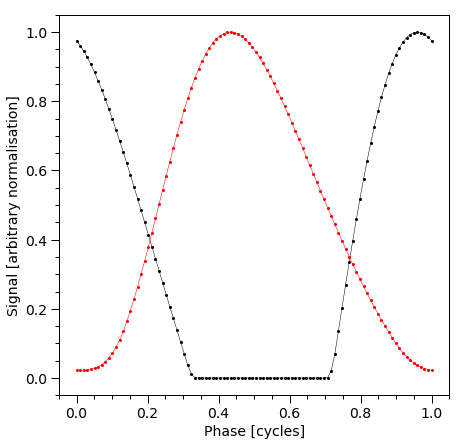

In [32]:
star['cos_inclination'] = math.cos(2.0)

star.update()
photosphere.integrate(energies, threads=1) # the number of OpenMP threads to use
_ = plot_pulse()

These pulse profiles are the signals incident on the telescope, before operating on them with the response model. The markers, linearly spaced in phase, denote the phase resolution.

The ``star.update`` method which in-turn calls the ``photosphere.embed`` method. We then call the ``photosphere.integrate`` method, passing the energies. Here we sum over incident specific photon flux pulses as an approximation to integrating over energy.

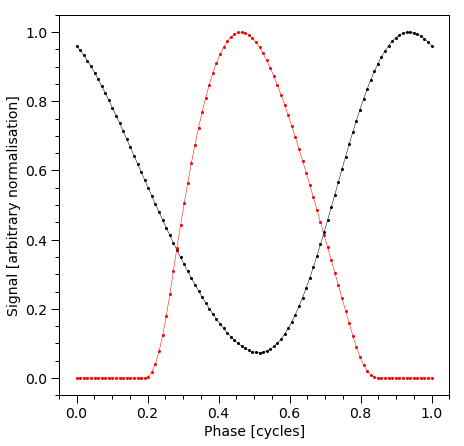

In [33]:
star['cos_inclination'] = math.cos(1.0)

star.update()
photosphere.integrate(energies, threads=1)

_ = plot_pulse()

Notice the solid pulses without markers are unchanged from the plot a few cells above, and can be used to guide the eye to the effect of a change in Earth inclination.

Below we print crude representations of the cell meshes spanning each hot region. The elements of a mesh cell-area array which are finite are not all identical: at the boundary of a hot region the proper area elements are smaller because of partial coverage by radiating material. The sum of all finite proper areas effectively equals the total proper area within a hot-region boundary.

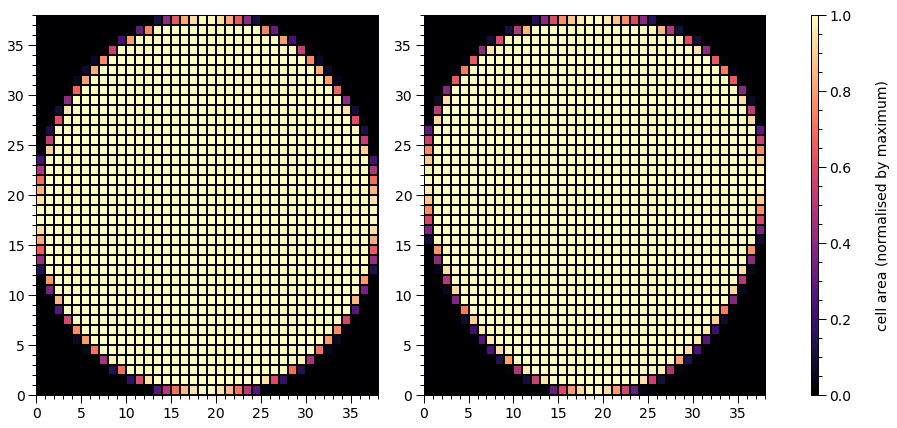

In [34]:
fig = plt.figure(figsize = (14,7))

gs = gridspec.GridSpec(1, 3, width_ratios=[50,50,1], wspace=0.2)
ax = plt.subplot(gs[0])
veneer((1,5), (1, 5), ax)

# primary (lower colatitude) hot region
h = hot.objects[0]
z = h._HotRegion__cellArea[0]/np.max(h._HotRegion__cellArea[0])
patches = plt.pcolormesh(z,
                         vmin = np.min(z),
                         vmax = np.max(z),
                         cmap = cm.magma,
                         linewidth = 1.0,
                         rasterized = True,
                         edgecolor='black')

ax = plt.subplot(gs[1])
veneer((1,5), (1, 5), ax)

# secondary (higher colatitude) hot region
h = hot.objects[1]
z = h._HotRegion__cellArea[0]/np.max(h._HotRegion__cellArea[0])
_ = plt.pcolormesh(z,
                   vmin = np.min(z),
                   vmax = np.max(z),
                   cmap = cm.magma,
                   linewidth = 1.0,
                   rasterized = True,
                   edgecolor='black')

ax_cb = plt.subplot(gs[2])
cb = plt.colorbar(patches,
                  cax = ax_cb,
                  ticks = MultipleLocator(0.2))

cb.set_label(label = r'cell area (normalised by maximum)', labelpad=25)
cb.solids.set_edgecolor('face')

veneer((None, None), (0.05, None), ax_cb)
cb.outline.set_linewidth(1.0)

Note that the lowest colatitude row is at zero on the y-axis.

Let's plot a pulse in two dimensions. Also note that we can interpolate the signal in phase as follows.

In [35]:
from xpsi.tools import phase_interpolator

In [36]:
def plot_2D_pulse(z, x, shift, y, ylabel, num_rotations=5.0, res=5000, cm=cm.viridis):
    """ Helper function to plot a phase-energy pulse.
    
    :param array-like z:
        A pair of *ndarray[m,n]* objects representing the signal at
        *n* phases and *m* values of an energy variable.
        
    :param ndarray[n] x: Phases the signal is resolved at.
        
    :param tuple shift: Hot region phase parameters.
    
    :param ndarray[m] x: Energy values the signal is resolved at.
    
    """
    
    fig = plt.figure(figsize = (12,6))

    gs = gridspec.GridSpec(1, 2, width_ratios=[50,1], wspace=0.025)
    ax = plt.subplot(gs[0])
    ax_cb = plt.subplot(gs[1])

    new_phases = np.linspace(0.0, num_rotations, res)

    interpolated = phase_interpolator(new_phases,
                                      x,
                                      z[0], shift[0])
    interpolated += phase_interpolator(new_phases,
                                       x,
                                       z[1], shift[1])

    profile = ax.pcolormesh(new_phases,
                             y,
                             interpolated/np.max(interpolated),
                             cmap = cm,
                             linewidth = 0,
                             rasterized = True)

    profile.set_edgecolor('face')

    ax.set_xlim([0.0, num_rotations])
    ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'Phase')
    veneer((0.1, 0.5), (None,None), ax)

    cb = plt.colorbar(profile,
                      cax = ax_cb,
                      ticks = MultipleLocator(0.2))

    cb.set_label(label=r'Signal (normalised by maximum)', labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((None, None), (0.05, None), ax_cb)
    cb.outline.set_linewidth(1.0)

The incident specific flux signal, in units of photons/cm$^{2}$/s/keV as output by the source code, and then normalised to the maximum in specific flux:

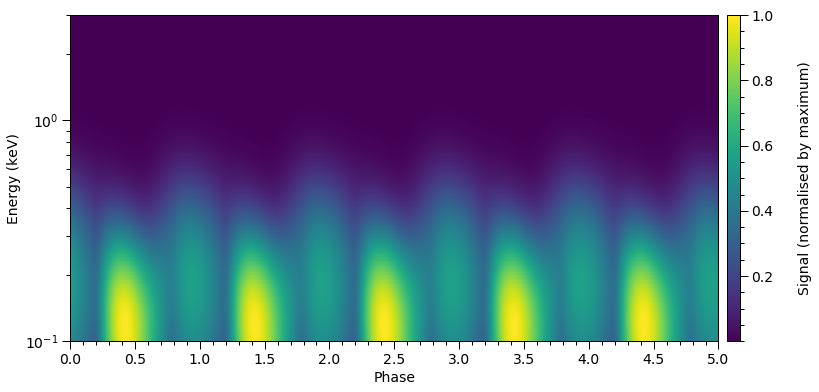

In [37]:
plot_2D_pulse((photosphere.signal[0][0], photosphere.signal[1][0]),
              x=hot.phases_in_cycles[0],
              shift=[ hot['p__phase_shift'], hot['s__phase_shift'] ],
              y=energies,
              ylabel=r'Energy (keV)')

Now we increase the phase resolution, and plot a single rotational pulse:

In [38]:
for obj in hot.objects:
    obj.set_phases(num_leaves = 1024)

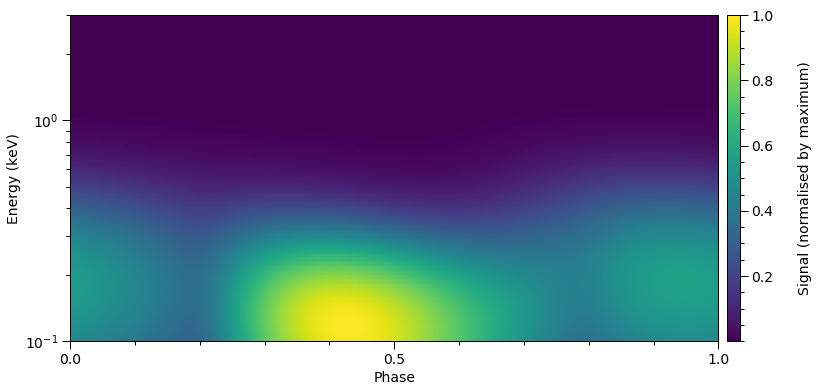

In [39]:
star.update()
photosphere.integrate(energies, threads=1)

temp = photosphere.signal[0][0] + photosphere.signal[1][0]

# the count rate signal is normalised with respect to the global maximum
# over channels and phase of the joint signal from the hot regions
plot_2D_pulse((photosphere.signal[0][0], photosphere.signal[1][0]),
              x=hot.phases_in_cycles[0],
              shift=[ hot['p__phase_shift'], hot['s__phase_shift'] ],
              y=energies,
              num_rotations=1.0,
              ylabel=r'Energy (keV)')

Let's iterate over a monotonically increasing set of values of the hot-region angular radius.

For objects that derive from ``ParameterSubspace`` we can get the current parameter vector in several ways:

In [40]:
star()

[1.4,
 12.5,
 0.2,
 0.5403023058681398,
 0.0,
 1.0,
 0.075,
 6.2,
 0.025,
 2.141592653589793,
 0.2]

In [41]:
star() == star.vector # possible shortcut to save some characters

True

Finally, let's play with some geometric parameters:

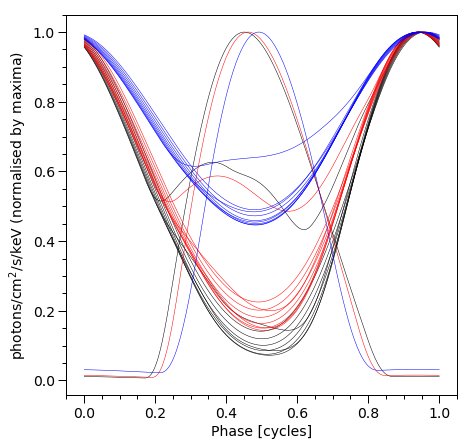

In [42]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_ylabel('photons/cm$^2$/s/keV (normalised by maxima)')
ax.set_xlabel('Phase [cycles]')

for obj in hot.objects:
    obj.set_phases(num_leaves = 256)

# let's play with the angular radius of the primary hot region
angular_radii = np.linspace(0.01, 1.0, 10)

star['cos_inclination'] = math.cos(1.25)

for angular_radius in angular_radii:
    star['p__super_radius'] = angular_radius # play time
    star.update()
    photosphere.integrate(energies, threads=3)
    temp = np.sum(photosphere.signal[0][0] + photosphere.signal[1][0], axis=0)
    _ = ax.plot(hot.phases_in_cycles[0], temp/np.max(temp), 'k-', lw=0.5)

star['cos_inclination'] = math.cos(1.0)
    
for angular_radius in angular_radii:
    star['p__super_radius'] = angular_radius
    star.update()
    photosphere.integrate(energies, threads=3)
    temp = np.sum(photosphere.signal[0][0] + photosphere.signal[1][0], axis=0)
    _ = ax.plot(hot.phases_in_cycles[0], temp/np.max(temp), 'r-', lw=0.5)

star['cos_inclination'] = math.cos(0.5)

for angular_radius in angular_radii:
    star['p__super_radius'] = angular_radius
    star.update()
    photosphere.integrate(energies, threads=3)
    temp = np.sum(photosphere.signal[0][0] + photosphere.signal[1][0], axis=0)
    _ = ax.plot(hot.phases_in_cycles[0], temp/np.max(temp), 'b-', lw=0.5)
    
veneer((0.05,0.2), (0.05,0.2), ax)

## Imaging

We can also image the photosphere to improve visualisation of the signal generation process. This is very brief: for more detail refer to the **Global surface emission** tutorial. We need to compile an appropriate extension module in order to compute local variables from the global variables. For this example, we require ``surface_radiation_field/archive/local_variables/twospots.pyx``, which needs to replace the contents of ``surface_radiation_field/local_variables.pyx`` (the X-PSI package will need to be reinstalled, and the Jupyter kernel restarted if this was not the case when the present kernel was launched).

In [43]:
spacetime.a = 0.0 # spacetime spin parameter (~angular momentum)
spacetime.q = 0.0 # spacetime mass quadrupole moment

In [44]:
sky_map_kwargs = {'panel_indices': (0,1,2,3,4,5),
                  'num_levels': 100, # in intensity field rendering
                  'colormap': cm.Purples_r,   # a colormap like this will make the lowest finite
                  'phase_average': False,     # intensity distinct from the black zero-intensity
                  'annotate_energies': True,  # background from the surface and behind the star
                  'energy_annotation_format': '[%.2f keV]',
                  'annotate_location': (0.025,0.025)}
    
# you can install ffmpeg with conda in order to animate
animate_kwargs = {'cycles': 8, 'fps': 32}

In [45]:
# later we will choose a higher phase resolution in
# order to phase-average, because it reduces artefacts
# that manifest due to the hard boundary of the hot regions
for obj in hot.objects:               
    obj.set_phases(num_leaves = 96) # animation will have 3 second period

In [46]:
star['p__super_radius'] = 0.1

In [47]:
photosphere.image(reimage = True,
                  cache_intensities = 1.0, # cache size limit in GBs
                  energies = np.array([0.01,0.1,0.5,1.0,2.0,5.0]),
                  phases = hot.phases_in_cycles[0] * _2pi,
                  sqrt_num_rays = 400,
                  threads = 4,
                  max_steps = 100000,
                  epsrel_ray = 1.0e-12,
                  plot_sky_maps = True, # activate if you want to plot frames
                  sky_map_kwargs = sky_map_kwargs,
                  animate_sky_maps = True, # activate if you want to animate
                  free_memory = True, # try to free ray-map/intensity cache memory before animating
                  animate_kwargs = animate_kwargs)

Imaging the star...
Commencing ray tracing and imaging...
Ray tracing complete.
Ray set cached.
Intensity caching complete.
Plotting intensity sky maps...
Normalising each sky map panel separately...
Normalised sky map panels separately.
Rendering images for phase numbers [1, 10]...
Rendering images for phase numbers (10, 20]...
Rendering images for phase numbers (20, 30]...
Rendering images for phase numbers (30, 40]...
Rendering images for phase numbers (40, 50]...
Rendering images for phase numbers (50, 60]...
Rendering images for phase numbers (60, 70]...
Rendering images for phase numbers (70, 80]...
Rendering images for phase numbers (80, 90]...
Rendering images for phase numbers (90, 100]...
Intensity sky maps plotted.
Animating intensity sky maps...
Writing to disk: ./images/skymap_animated.mp4...
Intensity sky maps animated.
Star imaged.


In [48]:
%%HTML
<div align="middle">
<video width="100%" controls loop>                                                                                                                   
    <source src="images/skymap_animated.mp4" type="video/mp4">                                                                     
</video></div>

In [49]:
!mkdir images/frames_twospots
!mv images/*.png images/frames_twospots/.

In [50]:
from IPython.display import Image

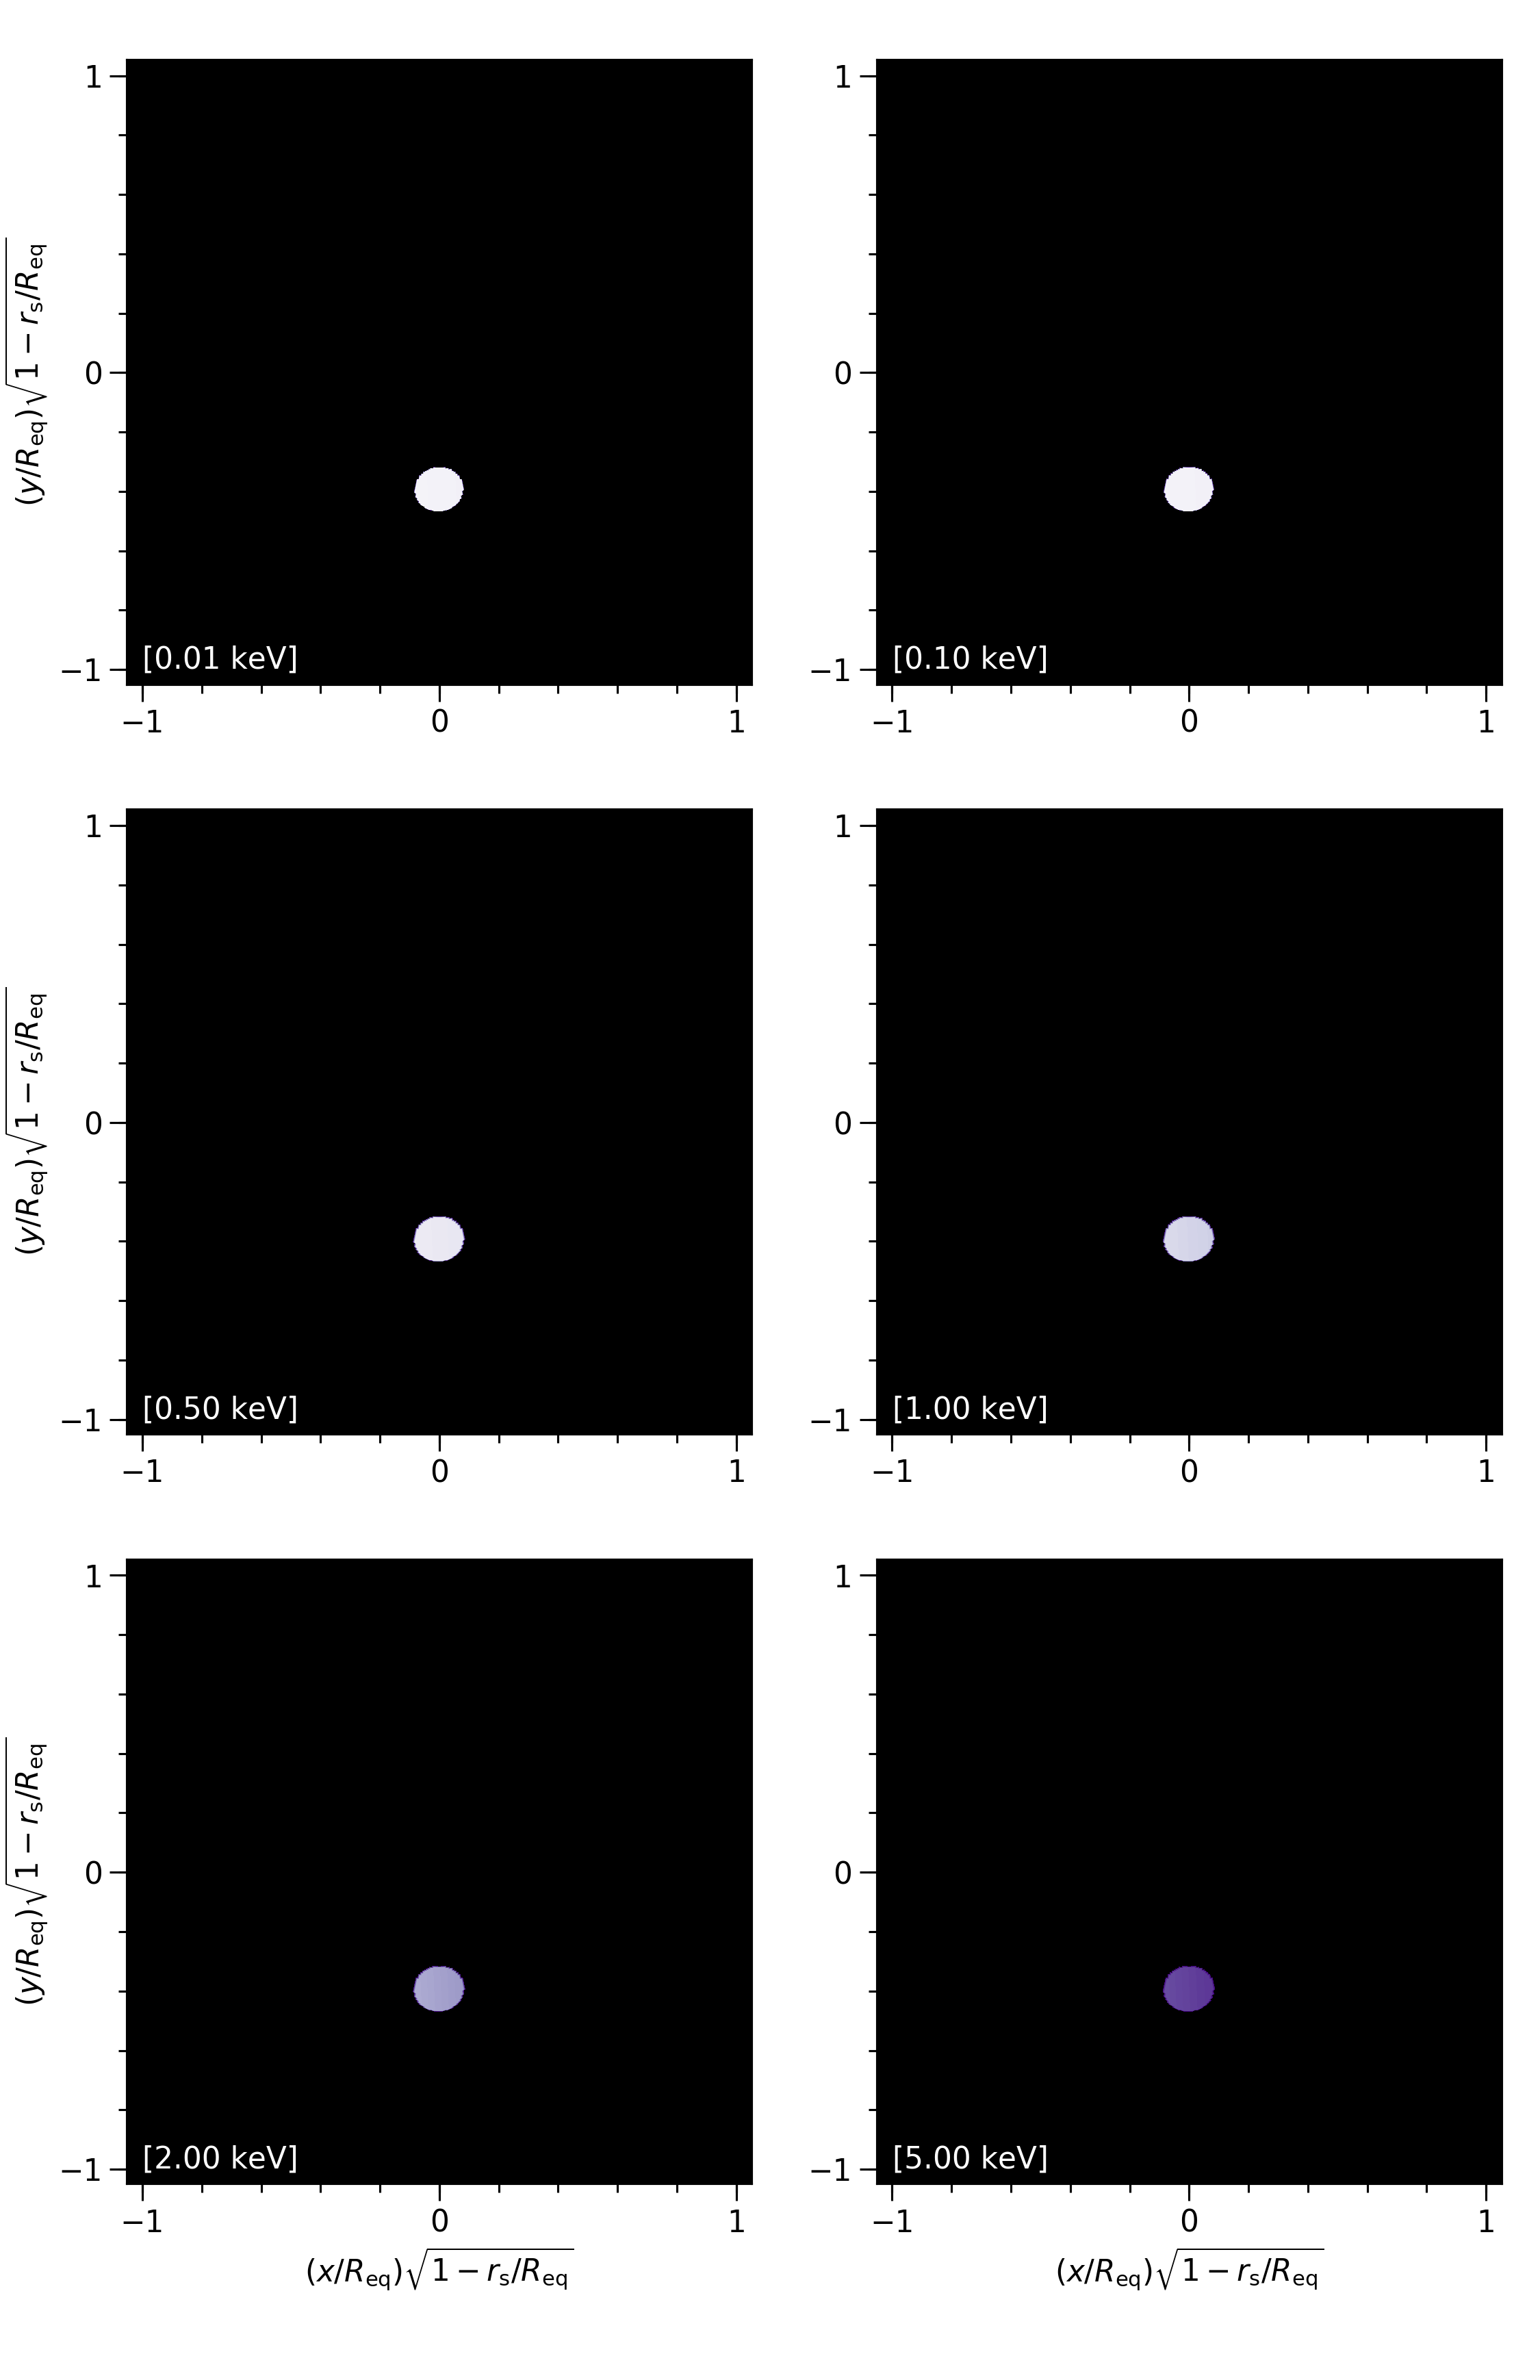

In [51]:
Image("./images/frames_twospots/skymap_0.png")

We freed memory above before animating, and thus lost the cached ray map and intensity cache. The ray map will now be recomputed, and the intensities cached again:

In [52]:
sky_map_kwargs['phase_average'] = True
# only one set of panels so why not choose higher res.?
sky_map_kwargs['num_levels'] = 500

for obj in hot.objects:               
    obj.set_phases(num_leaves = 260)

photosphere.image(reimage = True,
                  cache_intensities = 1.0, # cache size limit in GBs
                  energies = np.array([0.01,0.1,0.5,1.0,2.0,5.0]),
                  phases = hot.phases_in_cycles[0] * _2pi,
                  sqrt_num_rays = 400,
                  threads = 4,
                  max_steps = 100000,
                  epsrel_ray = 1.0e-12,
                  plot_sky_maps = True,
                  sky_map_kwargs = sky_map_kwargs)

Imaging the star...
Commencing ray tracing and imaging...
Ray tracing complete.
Ray set cached.
Intensity caching complete.
Plotting intensity sky maps...
Averaging (specific) intensity over rotational phase...
Averaged (specific) intensity over rotational phase.
Normalising each sky map panel separately...
Normalised sky map panels separately.
Rendering phase-averaged images...
Intensity sky maps plotted.
Star imaged.


In [55]:
!mv images/skymap_0.png images/frames_twospots/skymap_phase_averaged.png

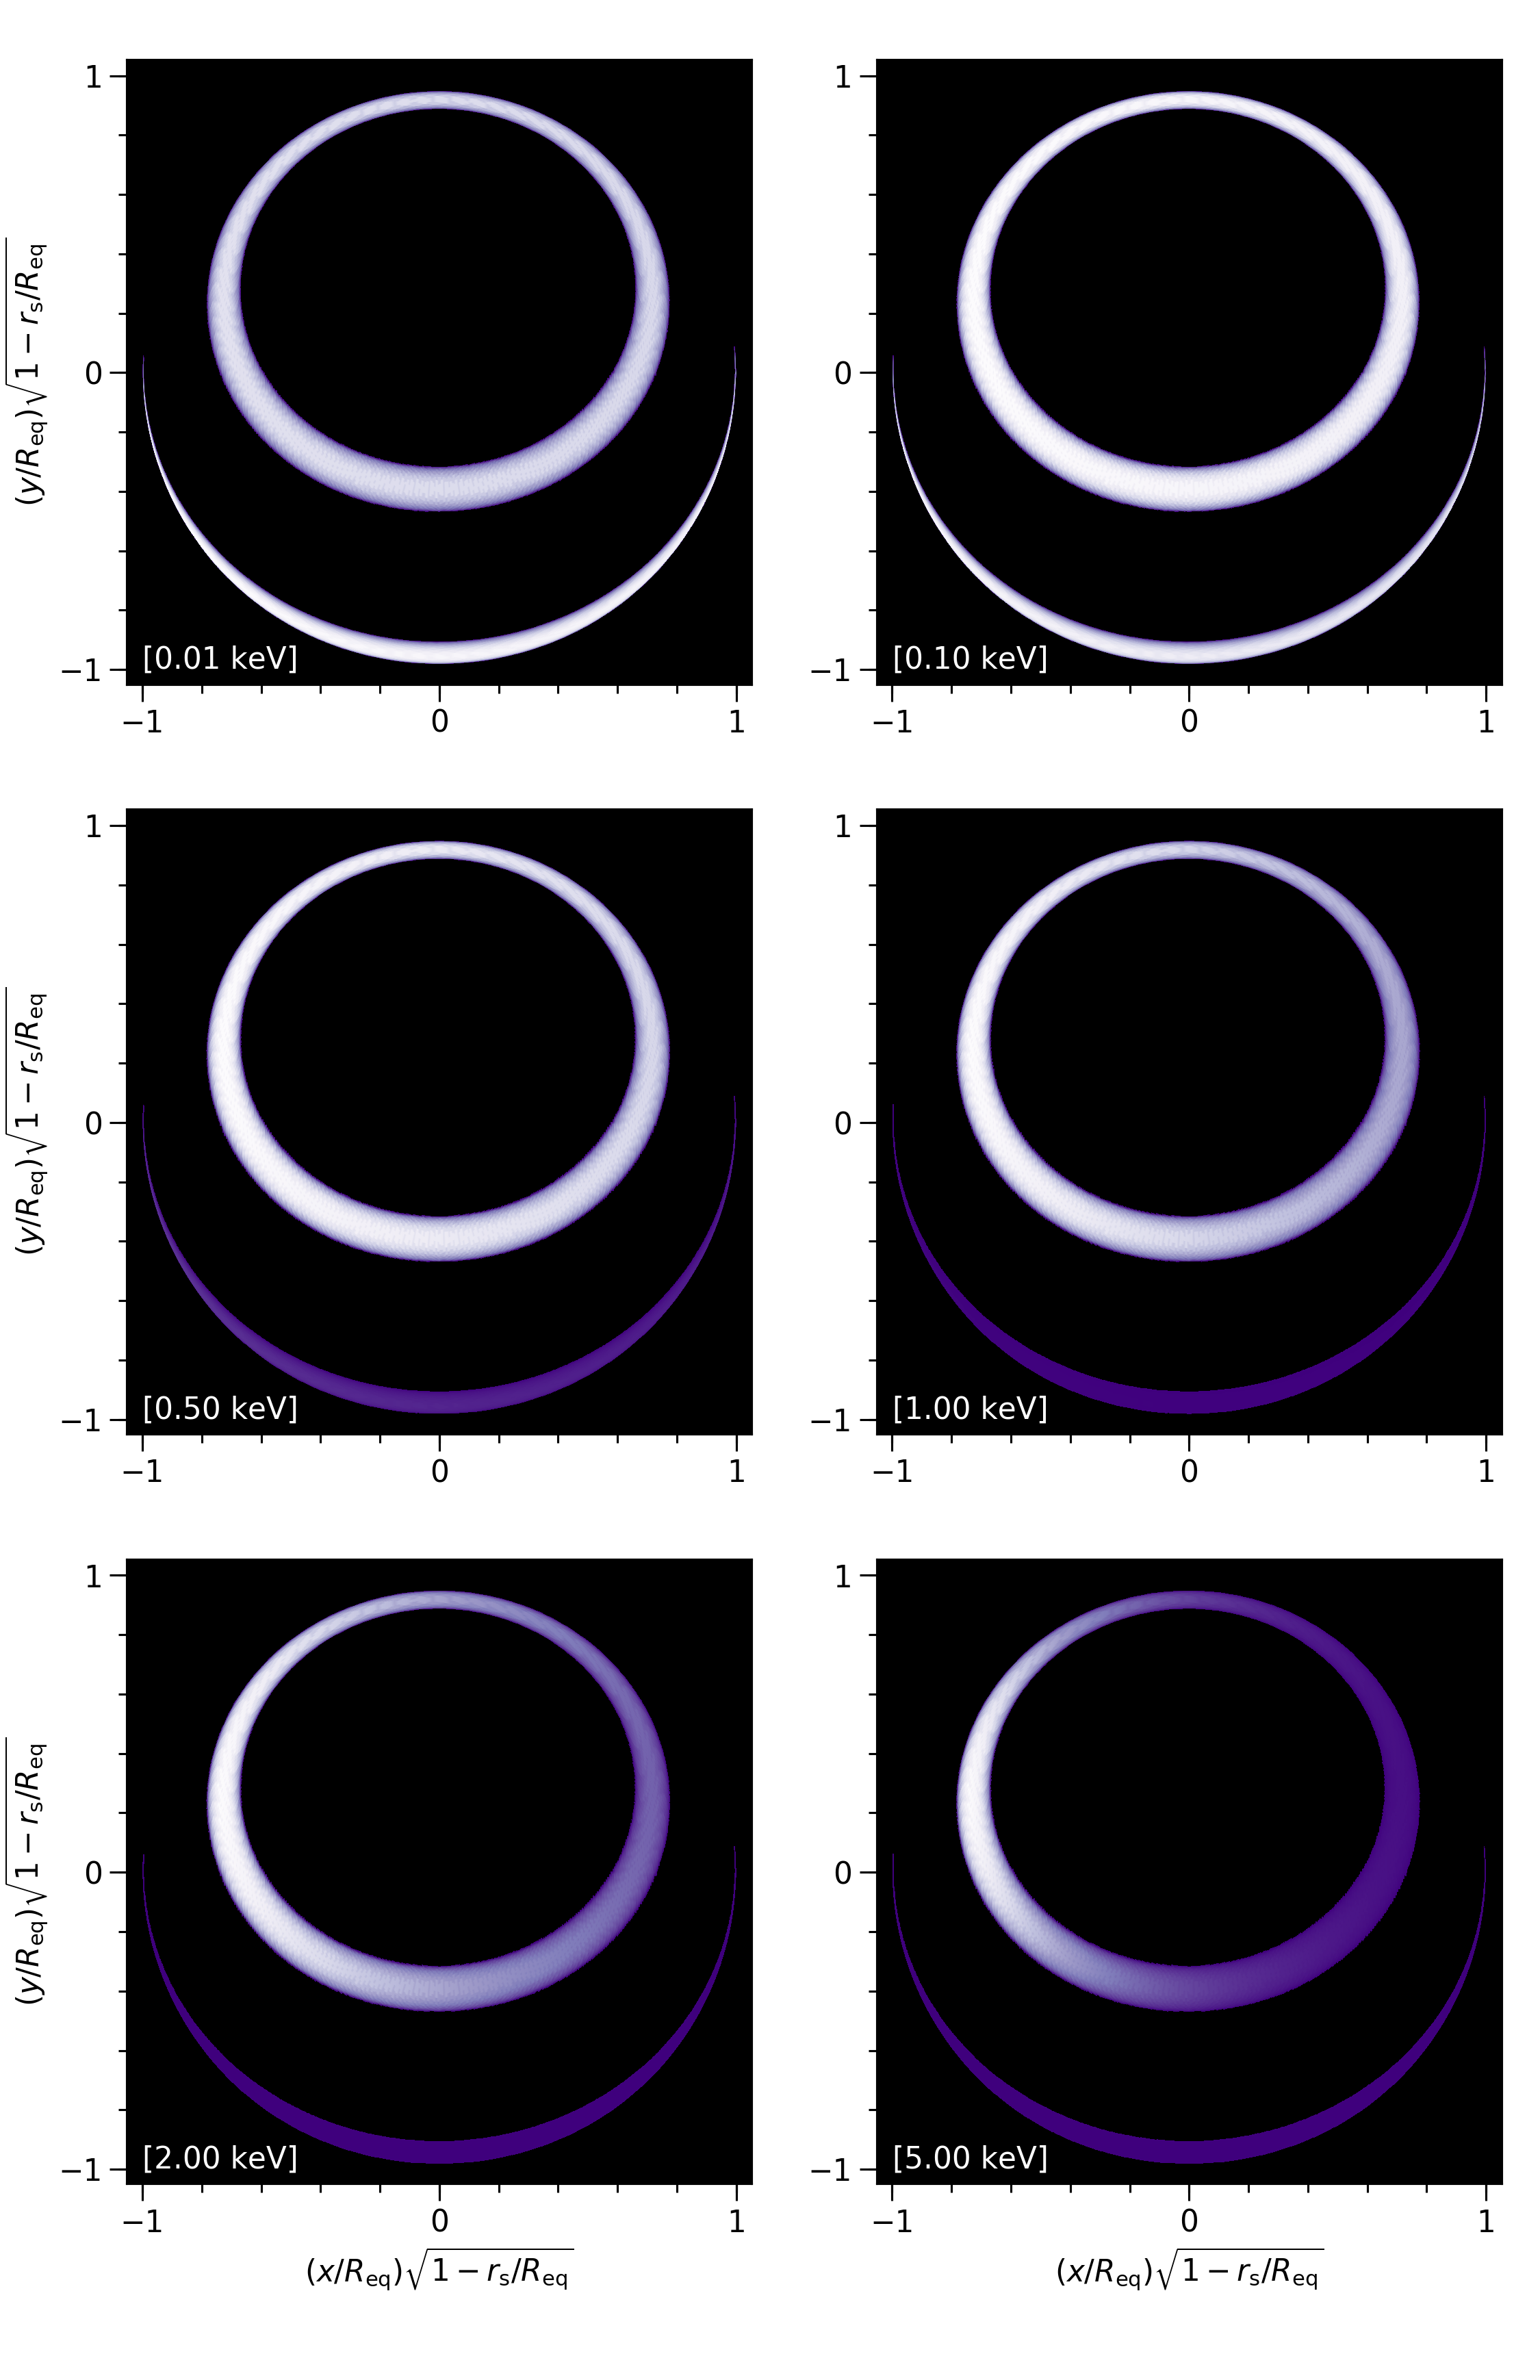

In [56]:
Image("images/frames_twospots/skymap_phase_averaged.png")

Artefacts are not very discernable, but can be further reduced with a higher phase resolution at higher memory and time cost.

## Summary

In this notebook we constructed a model star and simulated some pulsed X-ray signals.